# 1.加载波士顿房价数据集

In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


In [7]:
print(train_data.shape)
print(train_targets.shape)
print(train_data[0])
print(train_targets)

(404, 13)
(404,)
[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  

# 2.数据标准化

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std
# 注意:用于测试数据标准化的均值和标准差都是在训练数据上计算得到的.在工作流程中,
#     你不能使用在测试数据上计算得到的任何结果,即使是像数据标准化这么简单的使用也不行.

# 3.构建网络

In [9]:
from keras import models
from keras import layers

In [10]:
def build_model():
    network = models.Sequential()
    network.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(1))
    network.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return network

# 4.K折交叉验证

In [11]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = list()

for i in range(k):
    print("processing fold #", i)
    # 准备验证数据:第k个分区的数据
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    # 准备训练数据
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples], 
        train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    
    # 构建keras模型,模型函数内部已经编译
    net = build_model()
    # 在训练数据上训练模型,训练模式(静默模式, verbose=0)
    net.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        batch_size=1,
        verbose=0
    )
    # 在验证数据上评估模型
    val_mse, val_mae = net.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
all_scores

[2.0956787838794217, 2.220593797098292, 2.859968412040484, 2.40535704039111]

In [14]:
np.mean(all_scores)  # 平均分数2.4比单一分数更可靠,这就是K折交叉验证的关键

2.3953995083523267

# 5.保存每折的验证结果

In [16]:
num_epochs = 500
all_mae_scores = list()

for i in range(k):
    print("processing fold #", i)
    # 准备验证数据:第k个分区的数据
    val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
    # 准备训练数据
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples], 
        train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0
    )
    
    # 构建keras模型,模型函数内部已经编译
    net = build_model()
    # 在训练数据上训练模型,训练模式(静默模式, verbose=0)
    history = net.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=1,
        verbose=0,
    )
    mae_history = history.history['val_mean_absolute_error']
    all_mae_scores.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


# 6.计算所有轮次中的K折验证分数平均值

In [32]:
average_mae_history = [np.mean([x[i] for x in all_mae_scores]) for i in range(num_epochs)]
print(all_mae_scores)
print('----------------')
print(average_mae_history)

[[3.5054827208566195, 3.0100189530023256, 2.659108303561069, 2.7066302252287913, 2.4661312858657083, 2.1965995259804303, 2.1984772068439145, 2.1062063179393804, 2.1180790155240805, 2.157569913580866, 2.3918579970255935, 2.006175938219127, 2.0194132540485645, 2.086619754829029, 2.0440980561889046, 2.0384163667659947, 1.8283724690427874, 1.9467459385937984, 1.8797857548930856, 2.024991262077105, 1.9084649133210134, 1.9380661615050665, 1.7767206701901879, 1.7618749259722115, 2.4728510922724656, 1.8104254562075774, 1.8752507124796953, 2.197789957027624, 1.982927124098976, 1.7669852039601543, 2.2446688755904094, 2.2279103817326007, 1.8132106006735622, 1.6961567850396184, 1.8929584946962867, 1.826035735630753, 1.7936158699564415, 1.9978089993542965, 2.1231816452328522, 1.7324498337094147, 2.1783958567251074, 1.9886571345943036, 2.095576465719997, 1.8829220214692672, 1.932571009834214, 1.7867541832498985, 1.703476329841236, 1.8047877349475823, 2.14931056523087, 2.1053672308969027, 1.836638965

# 7.绘制验证分数曲线

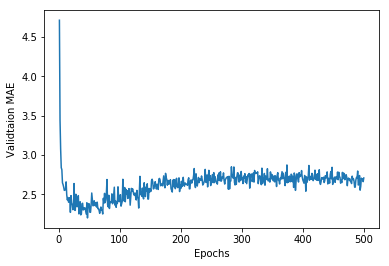

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validtaion MAE')
plt.show()

# 8.绘制验证分数曲线(删除前10个数据点)

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = list()
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])

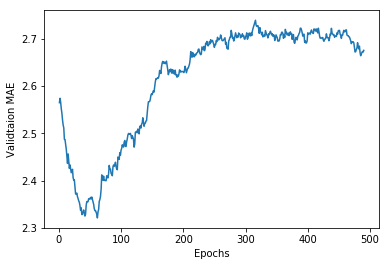

In [28]:
plt.clf()
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validtaion MAE')
plt.show()

# 9.训练最终模型

In [36]:
model = build_model()
model.fit(
    train_data, 
    train_targets,
    epochs=80,
    batch_size=16,
    verbose=0
)
test_loss, test_mae = model.evaluate(test_data, test_targets)
print(test_mae)

102/102 [==============================] - 0s 561us/step
2.5755113994373993
